# Import libraries

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go

import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

# Download file

In [5]:
file_id = "1DopC7bm_EWX_ocqbOIkME9usE5rG3pZE" # ID of the file on Google Drive
file_name = 'Customer_data_2021&2022.csv'

%run download.ipynb

# Import data

In [6]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
0,2021-01-01,Fri,13154,67.00,1118.00,NaN,37.00,1081.00,1118.00,443.55,271.25,0.40,0.24,288
1,2021-01-01,Fri,18379,54.00,40.00,NaN,40.00,NaN,40.00,0.00,40.00,0.00,1.00,1
2,2021-01-01,Fri,559232,63.00,12.00,NaN,NaN,12.00,12.00,9.50,2.04,0.79,0.17,5
3,2021-01-01,Fri,698904,69.00,1223.50,NaN,NaN,1223.50,1223.50,267.91,245.12,0.22,0.20,40
4,2021-01-01,Fri,762921,67.00,17.50,NaN,NaN,17.50,17.50,0.00,3.50,0.00,0.20,5


In [7]:
df[['DATE_DIM','BET_ACCOUNT_NUM_HASH']].nunique()

DATE_DIM                   730
BET_ACCOUNT_NUM_HASH    144877
dtype: int64

In [8]:
df.shape[0]

12365991

# EDA

## Column type conversion

In [103]:
# DATE_DIM: datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

## Missing value imputation

In [104]:
# No of missing values by columns
df.isna().sum()

DATE_DIM                       0
DAY_OF_WEEK                    0
BET_ACCOUNT_NUM_HASH           0
AGE                         2676
RACING_TURNOVER           959303
SPORT_TURNOVER          10575105
FOB_TURNOVER             2701974
PARI_TURNOVER            3829864
TURNOVER                       0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
WIN_LOSS_RATIO                 0
MARGIN_RATE                    0
TICKETS                        0
dtype: int64

2676 records are missing on 'AGE' column. Nan values on TURNOVER columns indicate zero value.

In [105]:
# See if it is possble impute age using other rows from the same customer
missing_age_lst = df.loc[df['AGE'].isna(), 'BET_ACCOUNT_NUM_HASH'].unique()

df[df['BET_ACCOUNT_NUM_HASH'].isin(missing_age_lst)].groupby('BET_ACCOUNT_NUM_HASH', as_index=False).AGE.min()

,BET_ACCOUNT_NUM_HASH,AGE
0,708049310,NaN
1,786895907,NaN
2,1080370257,NaN
3,1208532057,NaN
4,2100229039,NaN
5,2969320105,NaN
6,3111443700,NaN
7,3387748523,NaN
8,3461584997,NaN
9,3512123314,NaN


Only 10 customers

## Customer

In [106]:
# Aggregate data
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': 'max', 
                  'DATE_DIM': ['min', 'max', 'count'],
                  'RACING_TURNOVER' : 'sum', 
                  'SPORT_TURNOVER' : 'sum', 
                  'FOB_TURNOVER' : 'sum', 
                  'PARI_TURNOVER' : 'sum', 
                  'TURNOVER' : 'sum', 
                  'DIVIDENDS_PAID' : 'sum',
                  'GROSS_MARGIN' : 'sum', 
                  'TICKETS' : 'sum'})

# Rename columns
cus_df.columns = ["_".join(x).upper() if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]

# Create ratio columns
cus_df['RACING_TURNOVER_PER'] = cus_df['RACING_TURNOVER'] / cus_df['TURNOVER'] * 100
cus_df['SPORT_TURNOVER_PER'] = cus_df['SPORT_TURNOVER'] / cus_df['TURNOVER'] * 100
cus_df['FOB_TURNOVER_PER'] = cus_df['FOB_TURNOVER'] / cus_df['TURNOVER'] * 100
cus_df['PARI_TURNOVER_PER'] = cus_df['PARI_TURNOVER'] / cus_df['TURNOVER'] * 100

cus_df.head()

,BET_ACCOUNT_NUM_HASH,AGE,DATE_DIM_MIN,DATE_DIM_MAX,DATE_DIM_COUNT,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER_PER,SPORT_TURNOVER_PER,FOB_TURNOVER_PER,PARI_TURNOVER_PER
0,13154,67.00,2021-01-01,2022-12-31,463,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627,100.00,0.00,8.50,91.50
1,18379,54.00,2021-01-01,2022-12-31,199,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,841,99.69,0.31,87.48,12.52
2,37251,22.00,2022-11-01,2022-11-01,1,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7,100.00,0.00,65.00,35.00
3,129273,22.00,2021-12-26,2022-12-19,16,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37,40.00,60.00,100.00,0.00
4,348318,29.00,2022-06-10,2022-09-24,4,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17,83.33,16.67,90.00,10.00


In [107]:
# Quantity of unique customer
print("Total unique customers : ", cus_df.shape[0])

print("Total unique customers in 2021 : ", df.loc[df['DATE_DIM'].dt.year == 2021, 'BET_ACCOUNT_NUM_HASH'].nunique())

print("Total unique customers in 2022 : ", df.loc[df['DATE_DIM'].dt.year == 2022, 'BET_ACCOUNT_NUM_HASH'].nunique())

Total unique customers :  144877
Total unique customers in 2021 :  110534
Total unique customers in 2022 :  116495


In [108]:
# Impute missing age data with mean: 44
age_mean = round(cus_df['AGE'].mean()) 
cus_df.fillna(age_mean, inplace=True)

In [109]:
# Describe
cus_df.describe()

,AGE,DATE_DIM_COUNT,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER_PER,SPORT_TURNOVER_PER,FOB_TURNOVER_PER,PARI_TURNOVER_PER
count,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00
mean,43.68,85.36,13580.20,1575.24,8892.53,6262.92,15155.45,12527.94,2365.19,1888.08,85.07,14.93,64.26,35.74
std,15.92,142.09,55655.85,22389.91,47384.05,28982.81,61888.19,54219.50,9365.80,8881.82,29.85,29.85,34.20,34.20
min,18.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-327327.36,1.00,0.00,0.00,0.00,0.00
25%,31.00,3.00,100.00,0.00,75.00,11.00,163.00,73.10,20.00,17.00,90.36,0.00,36.78,3.24
50%,41.00,18.00,722.00,5.00,491.00,138.00,992.50,738.18,150.00,101.00,99.89,0.11,74.47,25.53
75%,55.00,98.00,5965.00,139.00,3605.00,1492.50,7070.00,5905.03,1060.38,700.00,100.00,9.64,96.76,63.22
max,104.00,730.00,5234120.84,2849523.33,4399559.00,3599772.50,5544861.46,4507251.65,467391.88,699955.00,100.00,100.00,100.00,100.00


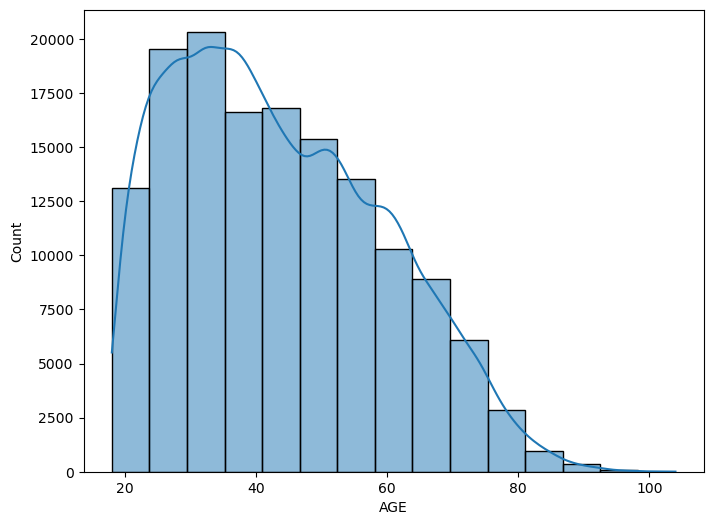

In [110]:
# Age distribution
plt.figure(figsize=(8,6))
sns.histplot(cus_df['AGE'], kde=True, bins=15)
plt.show();

Pretty normal with a right tail

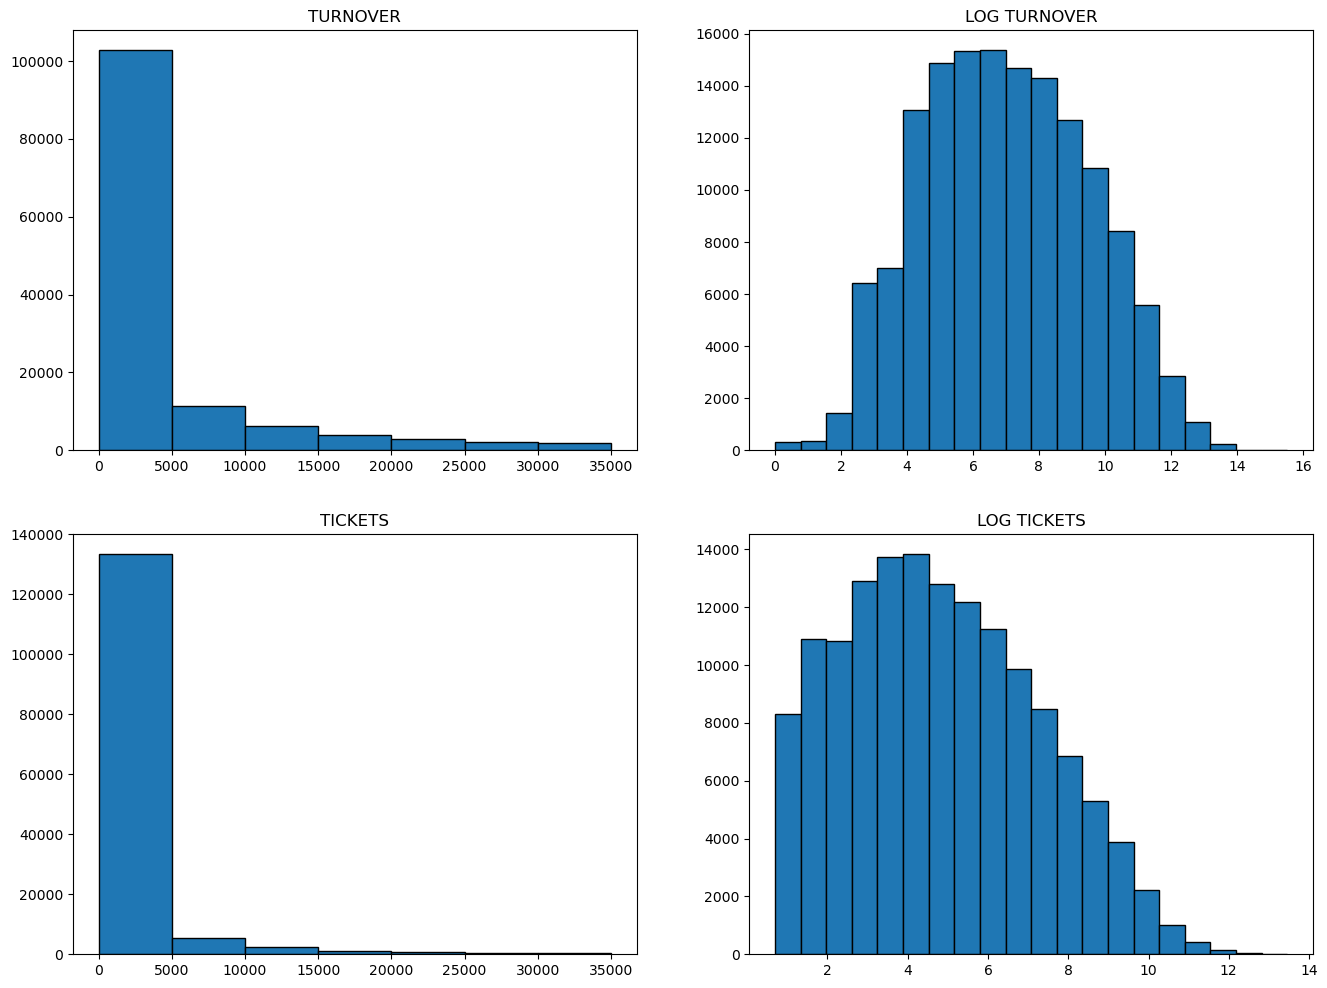

In [111]:
# TURNOVER and TICKETS

fig, ax = plt.subplots(2,2, figsize=(16,12))

ax[0,0].hist(cus_df['TURNOVER'], bins=range(0,40000, 5000), edgecolor='black')
ax[0,0].set_title('TURNOVER')

ax[0,1].hist(np.log(cus_df['TURNOVER']+1), bins=20, edgecolor='black')
ax[0,1].set_title('LOG TURNOVER')

ax[1,0].hist(cus_df['TICKETS'], bins=range(0,40000, 5000), edgecolor='black')
ax[1,0].set_title('TICKETS')

ax[1,1].hist(np.log(cus_df['TICKETS']+1), bins=20, edgecolor='black')
ax[1,1].set_title('LOG TICKETS')

plt.show();

We notice exponential decays with these two distributions. Therefore, a log transformation would work great here to convert the distribution in Gaussian when modelingm.

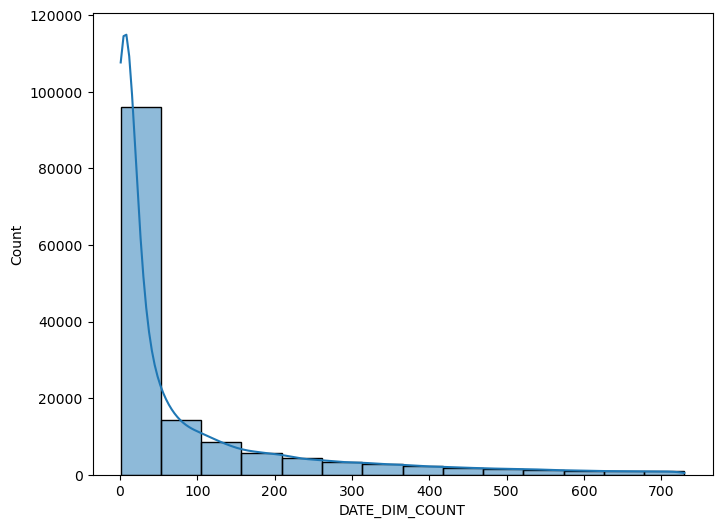

In [112]:
# DIM_DATE_COUNT
plt.figure(figsize=(8,6))

sns.histplot(cus_df['DATE_DIM_COUNT'], kde=True, bins=14)

plt.show();

Log transformation doesn't work as well here.

In [113]:
# Pearson correllation coefficient
cus_df[['AGE', 'DATE_DIM_COUNT', 'TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].corr()

,AGE,DATE_DIM_COUNT,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
AGE,1.00,0.36,0.10,0.08,0.13,0.12
DATE_DIM_COUNT,0.36,1.00,0.44,0.41,0.49,0.48
TURNOVER,0.10,0.44,1.00,0.99,0.77,0.35
DIVIDENDS_PAID,0.08,0.41,0.99,1.00,0.69,0.30
GROSS_MARGIN,0.13,0.49,0.77,0.69,1.00,0.46
TICKETS,0.12,0.48,0.35,0.30,0.46,1.00


DIVIDENDS_PAID almost completely linearly correlate with TURNOVER. GROSS_MARGIN has a considerably strong correlation with TURNOVER too. AGE and TICKETS appear to be weakly related to TURNOVER.

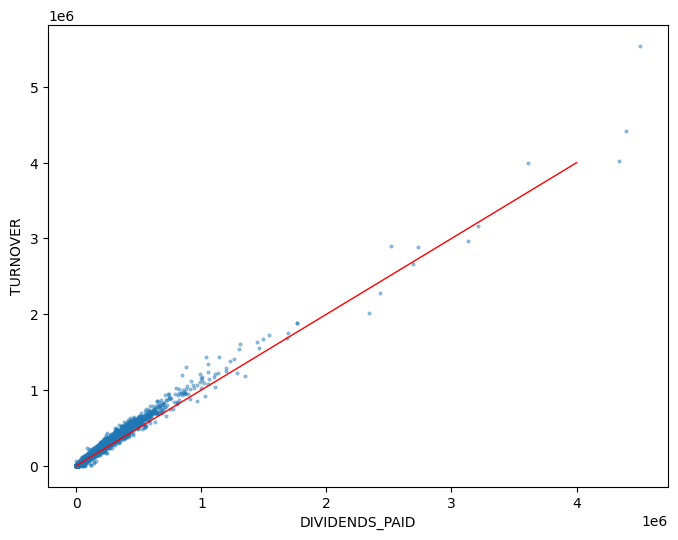

In [114]:
# TURNOVER vs DIVIDENDS_PAID 

plt.figure(figsize=(8,6))

plt.scatter(cus_df['DIVIDENDS_PAID'], cus_df['TURNOVER'], s=4, alpha=0.4)
plt.plot([0, 4e6], [0, 4e6], linewidth=1, c='r' )

plt.xlabel('DIVIDENDS_PAID')
plt.ylabel('TURNOVER')
plt.show();

I might seem that the more you invest, the bigger you win. That's only half of the story. The red line indicates the break even boundary. We have to analyze the variance to truly understand the risk.

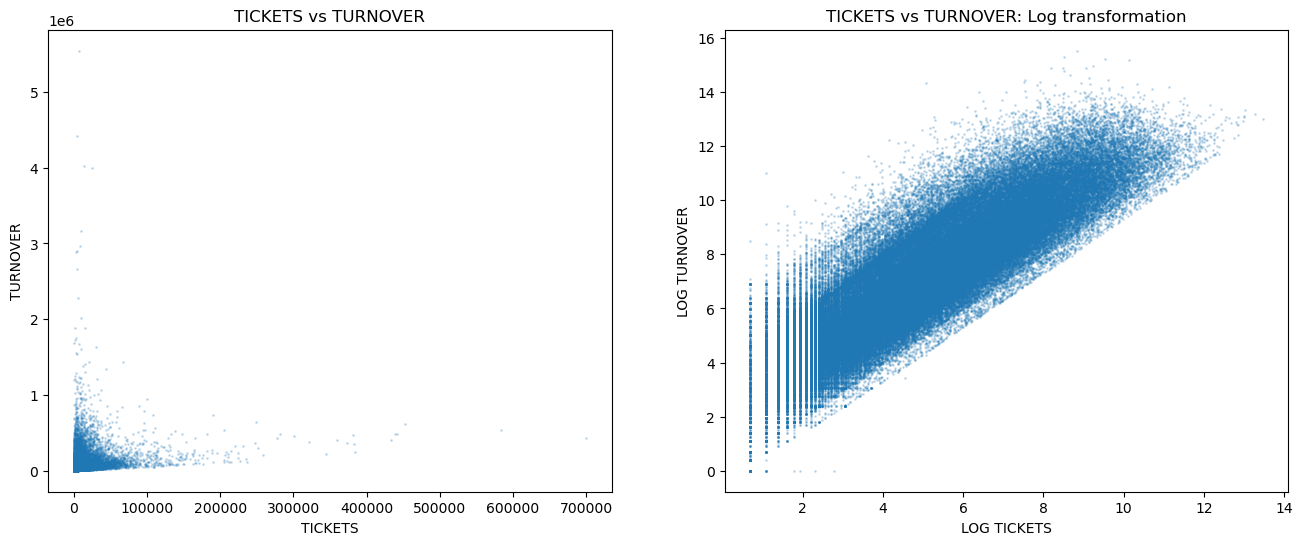

In [115]:
# TURNOVER vs TICKETS
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(cus_df['TICKETS'] , cus_df['TURNOVER'] , s=1, alpha=0.2)
ax[0].set_title('TICKETS vs TURNOVER')
ax[0].set_xlabel('TICKETS')
ax[0].set_ylabel('TURNOVER')

ax[1].scatter(np.log(cus_df['TICKETS']+1) , np.log(cus_df['TURNOVER']+1) , s=1, alpha=0.2)
ax[1].set_title('TICKETS vs TURNOVER: Log transformation')
ax[1].set_xlabel('LOG TICKETS')
ax[1].set_ylabel('LOG TURNOVER')

plt.show()

We detect strong heteroscedascity between TICKETS and TURNOVER (left fig). Therefore, we log transform both columns to achieve balanced variance (right fig).

In [116]:
#LOG TURNOVER and LOG TICKETS corr
np.corrcoef(np.log(cus_df['TURNOVER']+1), np.log(cus_df['TICKETS']+1))[0,1]

0.8778738254582013

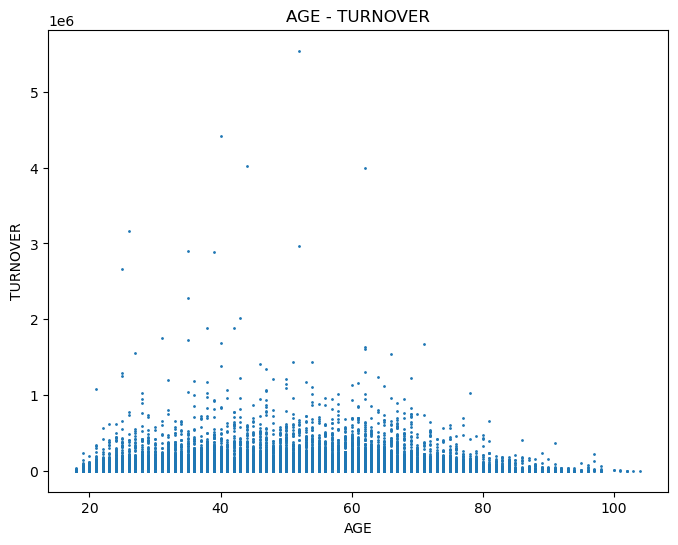

In [117]:
# AGE vs TURNOVER
plt.figure(figsize=(8,6))

plt.scatter(cus_df['AGE'] , cus_df['TURNOVER'] , s=1)
plt.title('AGE - TURNOVER')
plt.xlabel('AGE')
plt.ylabel('TURNOVER')

plt.show()

No correllation

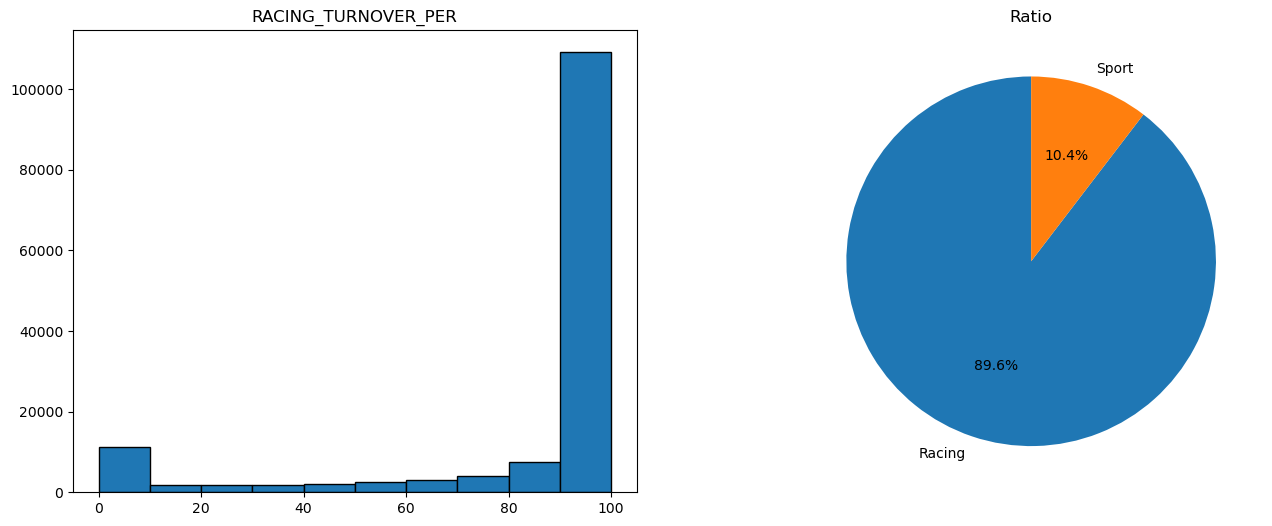

In [118]:
# RACING_TURNOVER vs SPORT_TURNOVER
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].hist(cus_df['RACING_TURNOVER_PER'], bins=10, edgecolor='black')
ax[0].set_title('RACING_TURNOVER_PER')

ax[1].pie(cus_df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0), labels= ["Racing", 'Sport'], autopct='%1.1f%%', startangle=90)
ax[1].set_title('Ratio')

plt.show();

Most people most of their money on horse racing instead of other sports (most presumingly Australian football). However, tt's noteworthy to point out that a considerable amount of customers like to spend 90% of their money on other sports. 

<Axes: xlabel='DATE_DIM'>

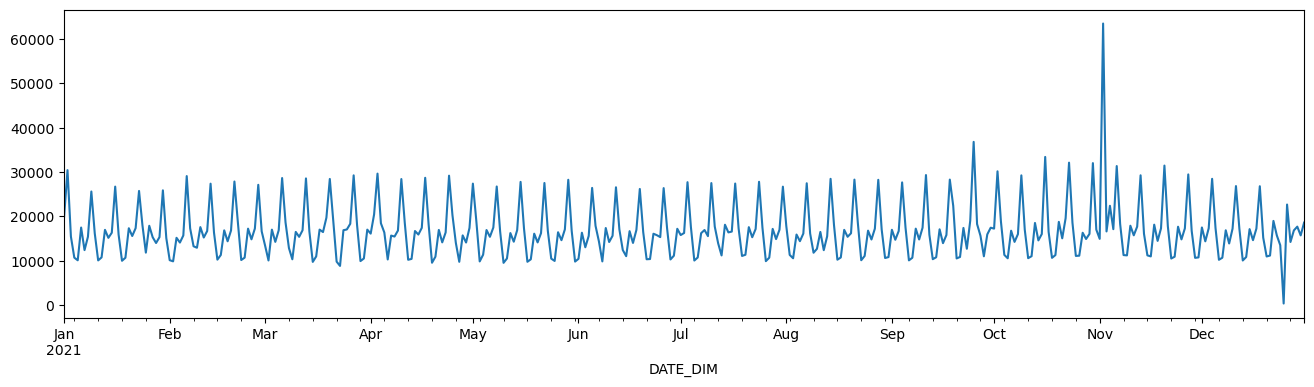

In [119]:
plt.figure(figsize=(16,4))

cus_num_df = df.set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.count()

cus_num_df[:365].plot()

Weekly cycle. High on the weekends.

## TURNOVER

In [120]:
# Aggregate

df_turnover = df.set_index('DATE_DIM').resample('d')[['RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 'TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].sum()
df_turnover['RACING_TURNOVER_PER'] = df_turnover['RACING_TURNOVER'] / df_turnover['TURNOVER'] * 100
df_turnover['SPORT_TURNOVER_PER'] = df_turnover['SPORT_TURNOVER'] / df_turnover['TURNOVER'] * 100
df_turnover['FOB_TURNOVER_PER'] = df_turnover['FOB_TURNOVER'] / df_turnover['TURNOVER'] * 100
df_turnover['PARI_TURNOVER_PER'] = df_turnover['PARI_TURNOVER'] / df_turnover['TURNOVER'] * 100
df_turnover.head()

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER_PER,SPORT_TURNOVER_PER,FOB_TURNOVER_PER,PARI_TURNOVER_PER
DATE_DIM,,,,,,,,,,,,
2021-01-01,3677157.56,160587.45,1902630.00,1935115.01,3837745.01,3117143.65,611881.33,488336,95.82,4.18,49.58,50.42
2021-01-02,5912241.48,257703.55,3591432.50,2578512.53,6169945.03,4954599.14,1109035.03,698384,95.82,4.18,58.21,41.79
2021-01-03,1871370.98,336212.21,1271655.50,935927.69,2207583.19,1841094.03,324655.16,280780,84.77,15.23,57.60,42.40
2021-01-04,1207880.74,322013.93,914797.50,615097.17,1529894.67,1295588.11,197903.31,194882,78.95,21.05,59.79,40.21
2021-01-05,1257028.61,225146.21,828628.50,653546.32,1482174.82,1215165.78,251711.36,201692,84.81,15.19,55.91,44.09


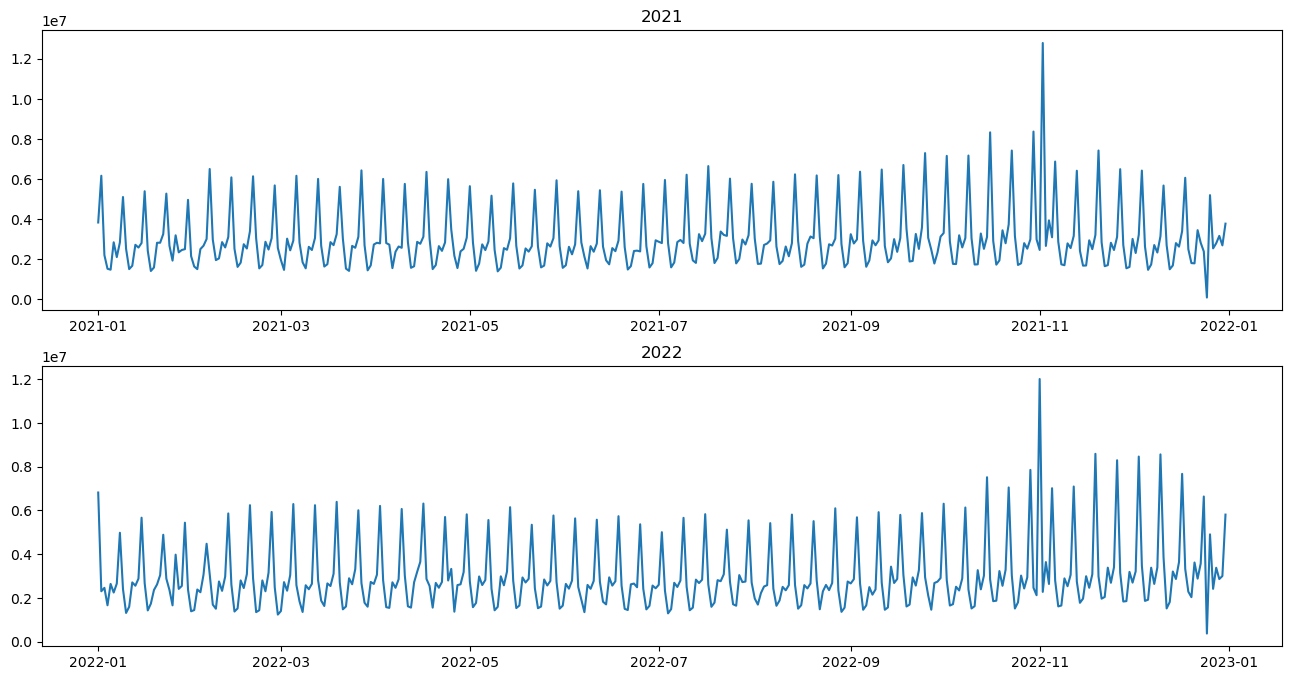

In [121]:
#2021 vs 2022

df_turnover_2021 = df_turnover[df_turnover.index.year == 2021]
df_turnover_2022 = df_turnover[df_turnover.index.year == 2022]

fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_turnover_2021['TURNOVER'])
ax[0].set_title('2021')

ax[1].plot(df_turnover_2022['TURNOVER'])
ax[1].set_title('2022')

plt.show()

In [122]:
max_date = df_turnover_2021.TURNOVER.argmax()
print(df_turnover_2021.index[max_date])

min_date = df_turnover_2021.TURNOVER.argmin()
print(df_turnover_2021.index[min_date])

2021-11-02 00:00:00
2021-12-25 00:00:00


Two anomalies:
- Min day: Christmas day
- Max day: Melbourne Cup

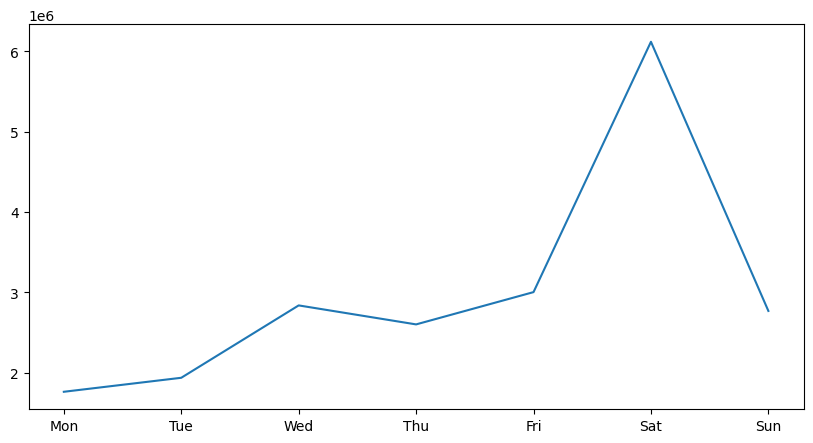

In [123]:
# Weekly
df_weekly = df_turnover.groupby(df_turnover.index.weekday).TURNOVER.mean()
df_weekly.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(df_weekly)

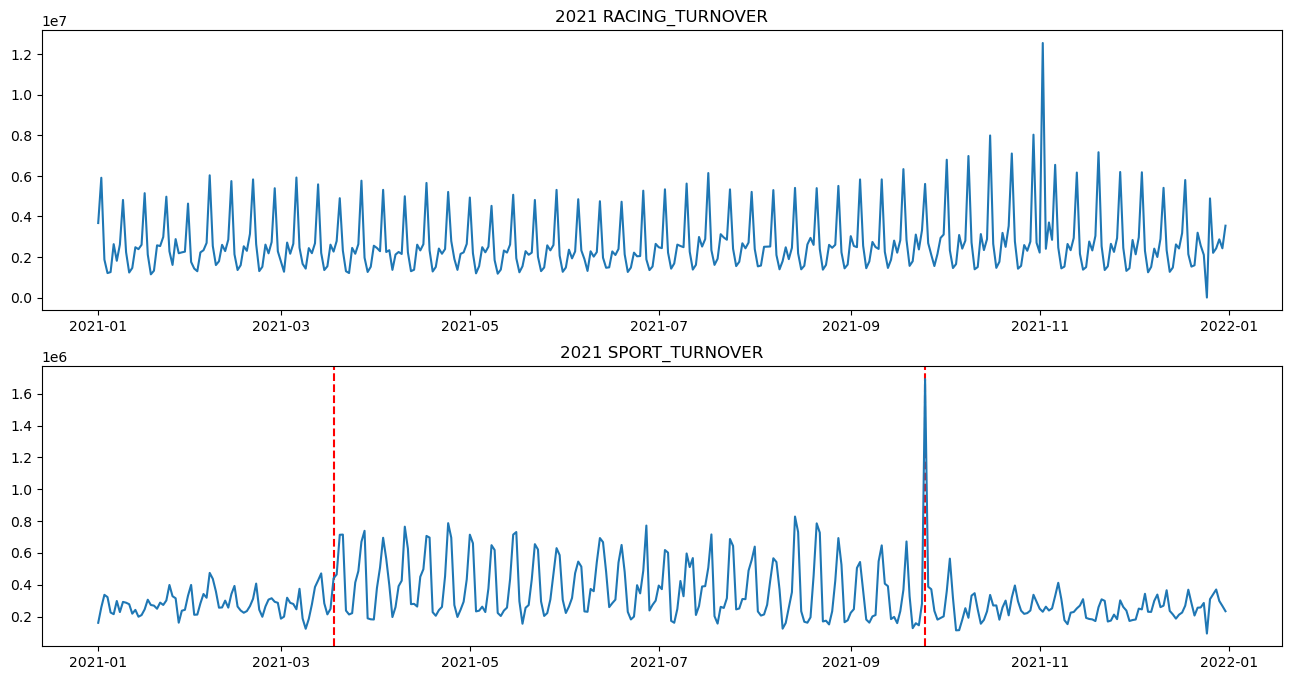

In [124]:
## 2021: RACING_TURNOVER vs SPORT_TURNOVER

fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_turnover_2021['RACING_TURNOVER'])
ax[0].set_title('2021 RACING_TURNOVER')

threshold_1 = datetime(2021, 3, 18)
threshold_2 = datetime(2021, 9, 25)
threshold_mpl_1 = mdates.date2num(threshold_1)
threshold_mpl_2 = mdates.date2num(threshold_2)

ax[1].axvline(threshold_mpl_1 , color='red', linestyle='--')
ax[1].axvline(threshold_mpl_2 , color='red', linestyle='--')

ax[1].plot(df_turnover_2021['SPORT_TURNOVER'])
ax[1].set_title('2021 SPORT_TURNOVER')

plt.show()

Surge during AFL Season: 2021-03-18 -> 2021-09-25. Final is on the last day.

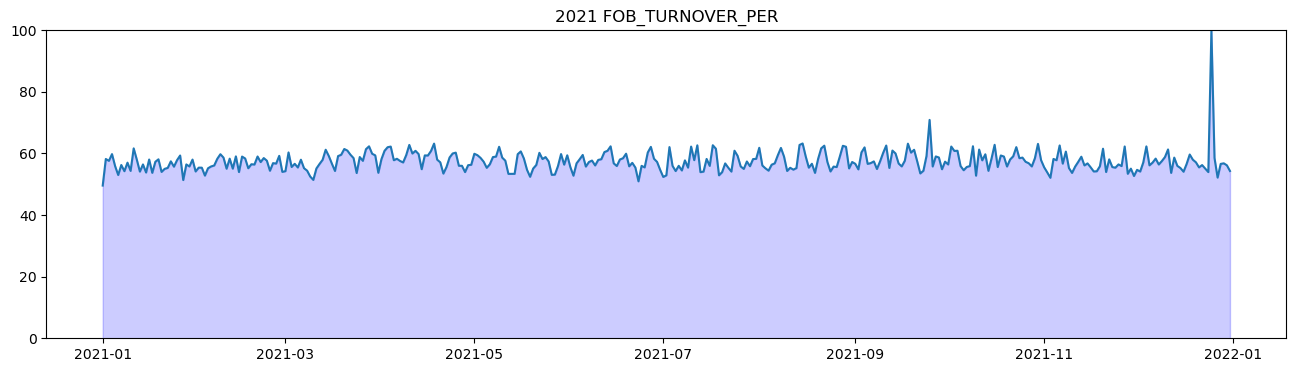

In [125]:
## 2021: RACING_TURNOVER vs SPORT_TURNOVER

fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_turnover_2021['FOB_TURNOVER_PER'])
ax.fill_between(df_turnover_2021['FOB_TURNOVER_PER'].index, df_turnover_2021['FOB_TURNOVER_PER'].values, color='blue', alpha=0.2)
ax.set_title('2021 FOB_TURNOVER_PER')
ax.set_ylim(0,100)

plt.show()

In [ ]:
cus_df['']